In [34]:
import pandas as pd
import numpy as np
import matplotlib as plt
import collections
from tqdm.auto import tqdm
from tensorboardX import SummaryWriter

import math
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [35]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

# Helpers

## Data

In [36]:
# The (A)NP takes as input a `NPRegressionDescription` namedtuple with fields:
#   `query`: a tuple containing ((context_x, context_y), target_x)
#   `target_y`: a tensor containing the ground truth for the targets to be
#     predicted
#   `num_total_points`: A vector containing a scalar that describes the total
#     number of datapoints used (context + target)
#   `num_context_points`: A vector containing a scalar that describes the number
#     of datapoints used as context
# The GPCurvesReader returns the newly sampled data in this format at each
# iteration

NPRegressionDescription = collections.namedtuple(
    "NPRegressionDescription",
    ("query", "target_y", "num_total_points", "num_context_points"))


class GPCurvesReader(object):
    """Generates curves using a Gaussian Process (GP).

  Supports vector inputs (x) and vector outputs (y). Kernel is
  mean-squared exponential, using the x-value l2 coordinate distance scaled by
  some factor chosen randomly in a range. Outputs are independent gaussian
  processes.
      """

    def __init__(self,
               batch_size,
               max_num_context,
               x_size=1,
               y_size=1,
               l1_scale=0.6,
               sigma_scale=1.0,
               random_kernel_parameters=True,
               testing=False):
        """Creates a regression dataset of functions sampled from a GP.

    Args:
      batch_size: An integer.
      max_num_context: The max number of observations in the context.
      x_size: Integer >= 1 for length of "x values" vector.
      y_size: Integer >= 1 for length of "y values" vector.
      l1_scale: Float; typical scale for kernel distance function.
      sigma_scale: Float; typical scale for variance.
      random_kernel_parameters: If `True`, the kernel parameters (l1 and sigma) 
          will be sampled uniformly within [0.1, l1_scale] and [0.1, sigma_scale].
      testing: Boolean that indicates whether we are testing. If so there are
          more targets for visualization.
        """
        self._batch_size = batch_size
        self._max_num_context = max_num_context
        self._x_size = x_size
        self._y_size = y_size
        self._l1_scale = l1_scale
        self._sigma_scale = sigma_scale
        self._random_kernel_parameters = random_kernel_parameters
        self._testing = testing

    def _gaussian_kernel(self, xdata, l1, sigma_f, sigma_noise=2e-2):
        """Applies the Gaussian kernel to generate curve data.

    Args:
      xdata: Tensor of shape [B, num_total_points, x_size] with
          the values of the x-axis data.
      l1: Tensor of shape [B, y_size, x_size], the scale
          parameter of the Gaussian kernel.
      sigma_f: Tensor of shape [B, y_size], the magnitude
          of the std.
      sigma_noise: Float, std of the noise that we add for stability.

    Returns:
      The kernel, a float tensor of shape
      [B, y_size, num_total_points, num_total_points].
        """
        num_total_points = xdata.shape[1]

    # Expand and take the difference
        xdata1 = xdata.unsqueeze(1)  # [B, 1, num_total_points, x_size]
        xdata2 = xdata.unsqueeze(2)  # [B, num_total_points, 1, x_size]
        diff = xdata1 - xdata2  # [B, num_total_points, num_total_points, x_size]

    # [B, y_size, num_total_points, num_total_points, x_size]
        norm = (diff[:, None, :, :, :] / l1[:, :, None, None, :])**2

        norm = torch.sum(norm, -1)  # [B, data_size, num_total_points, num_total_points]

    # [B, y_size, num_total_points, num_total_points]
        kernel = ((sigma_f)**2)[:, :, None, None] * torch.exp(-0.5 * norm)

    # Add some noise to the diagonal to make the cholesky work.
        kernel += (sigma_noise**2) * torch.eye(num_total_points)

        return kernel

    def generate_curves(self):
        """Builds the op delivering the data.

    Generated functions are `float32` with x values between -2 and 2.
    
    Returns:
      A `CNPRegressionDescription` namedtuple.
        """
        num_context = int(np.random.rand()*(self._max_num_context - 3) + 3)
    # If we are testing we want to have more targets and have them evenly
    # distributed in order to plot the function.
        if self._testing:
            num_target = 400
            num_total_points = num_target
            x_values = torch.arange(-2, 2, 1.0/100).unsqueeze(0).repeat(self._batch_size, 1)
            x_values = x_values.unsqueeze(-1)
    # During training the number of target points and their x-positions are
    # selected at random
        else:
            num_target = int(np.random.rand()*(self._max_num_context - num_context))
            num_total_points = num_context + num_target
            x_values = torch.rand((self._batch_size, num_total_points, self._x_size))*4 - 2
            

    # Set kernel parameters
    # Either choose a set of random parameters for the mini-batch
        if self._random_kernel_parameters:
            l1 = torch.rand((self._batch_size, self._y_size, self._x_size))*(self._l1_scale - 0.1) + 0.1
            sigma_f = torch.rand((self._batch_size, self._y_size))*(self._sigma_scale - 0.1) + 0.1
            
    # Or use the same fixed parameters for all mini-batches
        else:
            l1 = torch.ones((self._batch_size, self._y_size, self._x_size))*self._l1_scale
            sigma_f = torch.ones((self._batch_size, self._y_size))*self._sigma_scale

    # Pass the x_values through the Gaussian kernel
    # [batch_size, y_size, num_total_points, num_total_points]
        kernel = self._gaussian_kernel(x_values, l1, sigma_f)

    # Calculate Cholesky, using double precision for better stability:
        cholesky = torch.cholesky(kernel)

    # Sample a curve
    # [batch_size, y_size, num_total_points, 1]
        y_values = torch.matmul(cholesky, torch.randn((self._batch_size, self._y_size, num_total_points, 1)))

    # [batch_size, num_total_points, y_size]
        y_values = y_values.squeeze(3)
        y_values = y_values.permute(0, 2, 1)

        if self._testing:
      # Select the targets
            target_x = x_values
            target_y = y_values

      # Select the observations
            idx = torch.randperm(num_target)
            context_x = x_values[:, idx[:num_context]]
            context_y = y_values[:, idx[:num_context]]

        else:
      # Select the targets which will consist of the context points as well as
      # some new target points
            target_x = x_values[:, :num_target + num_context, :]
            target_y = y_values[:, :num_target + num_context, :]

      # Select the observations
            context_x = x_values[:, :num_context, :]
            context_y = y_values[:, :num_context, :]

        query = ((context_x, context_y), target_x)

        return NPRegressionDescription(
        query=query,
        target_y=target_y,
        num_total_points=target_x.shape[1],
        num_context_points=num_context)


## Modules

In [37]:

class NPBlockRelu2d(nn.Module):
    """Block for Neural Processes."""

    def __init__(self, in_channels, out_channels, dropout=0, batchnorm=False, bias=False):
        super().__init__()
        self.linear = nn.Linear(in_channels, out_channels, bias=bias)
        self.act = nn.ReLU()
        self.dropout = nn.Dropout2d(dropout)
        self.norm = nn.BatchNorm2d(out_channels) if batchnorm else False

    def forward(self, x):
        # x.shape is (Batch, Sequence, Channels)
        # We pass a linear over it which operates on the Channels
        x = self.act(self.linear(x))

        # Now we want to apply batchnorm and dropout to the channels. So we put it in shape
        # (Batch, Channels, Sequence, None) so we can use Dropout2d
        x = x.permute(0, 2, 1)[:, :, :, None]

        if self.norm:
            x = self.norm(x)

        x = self.dropout(x)
        return x[:, :, :, 0].permute(0, 2, 1)


class BatchMLP(nn.Module):
    """Apply MLP to the final axis of a 3D tensor (reusing already defined MLPs).

    Args:
        input: input tensor of shape [B,n,d_in].
        output_sizes: An iterable containing the output sizes of the MLP as defined 
            in `basic.Linear`.
    Returns:
        tensor of shape [B,n,d_out] where d_out=output_size
    """

    def __init__(self, input_size, output_size, num_layers=2, dropout=0, batchnorm=False):
        super().__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.num_layers = num_layers
        
        
        self.initial = NPBlockRelu2d(input_size, output_size, dropout=dropout, batchnorm=batchnorm)
        self.encoder = nn.Sequential(* [
            NPBlockRelu2d(output_size, output_size, dropout=dropout, batchnorm=batchnorm) for _ in range(num_layers - 2)
        ])
        self.final = nn.Linear(output_size, output_size)

    def forward(self, x):
        x = self.initial(x)
        x = self.encoder(x)
        return self.final(x)

In [38]:
class AttnLinear(nn.Module):

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.linear = nn.Linear(in_channels, out_channels, bias=False)
        torch.nn.init.normal_(self.linear.weight, std=in_channels**-0.5)

    def forward(self, x):
        x = self.linear(x)
        return x


class Attention(nn.Module):
    def __init__(self, hidden_dim, attention_type, attention_layers=2, n_heads=8, x_dim=1, rep='mlp', dropout=0, batchnorm=False):
        super().__init__()
        self._rep = rep
        
        if self._rep == 'mlp':
            self.batch_mlp_k = BatchMLP(x_dim, hidden_dim, attention_layers, dropout=dropout, batchnorm=batchnorm)
            self.batch_mlp_q = BatchMLP(x_dim, hidden_dim, attention_layers, dropout=dropout, batchnorm=batchnorm)

        if attention_type == "uniform":
            self._attention_func = self._uniform_attention
        elif attention_type == "laplace":
            self._attention_func = self._laplace_attention
        elif attention_type == "dot":
            self._attention_func = self._dot_attention
        elif attention_type == "multihead":
            self._W_k = nn.ModuleList(
                [AttnLinear(hidden_dim, hidden_dim) for _ in range(n_heads)])
            self._W_v = nn.ModuleList(
                [AttnLinear(hidden_dim, hidden_dim) for _ in range(n_heads)])
            self._W_q = nn.ModuleList(
                [AttnLinear(hidden_dim, hidden_dim) for _ in range(n_heads)])
            self._W = AttnLinear(n_heads * hidden_dim, hidden_dim)
            self._attention_func = self._multihead_attention
            self.n_heads = n_heads
        elif attention_type == "ptmultihead":
            self._W = torch.nn.MultiheadAttention(
                hidden_dim, n_heads, bias=False, dropout=dropout
            )
            self._attention_func = self._pytorch_multihead_attention
        else:
            raise NotImplementedError

    def forward(self, k, v, q):
        if self._rep == 'mlp':
            k = self.batch_mlp_k(k)
            q = self.batch_mlp_q(q)
        rep = self._attention_func(k, v, q)
        return rep

    def _uniform_attention(self, k, v, q):
        total_points = q.shape[1]
        rep = torch.mean(v, dim=1, keepdim=True)
        rep = rep.repeat(1, total_points, 1)
        return rep

    def _laplace_attention(self, k, v, q, scale=0.5):
        k_ = k.unsqueeze(1)
        v_ = v.unsqueeze(2)
        unnorm_weights = torch.abs((k_ - v_) * scale)
        unnorm_weights = unnorm_weights.sum(dim=-1)
        weights = torch.softmax(unnorm_weights, dim=-1)
        rep = torch.einsum('bik,bkj->bij', weights, v)
        return rep

    def _dot_attention(self, k, v, q):
        scale = q.shape[-1]**0.5
        unnorm_weights = torch.einsum('bjk,bik->bij', k, q) / scale
        weights = torch.softmax(unnorm_weights, dim=-1)

        rep = torch.einsum('bik,bkj->bij', weights, v)
        return rep

    def _multihead_attention(self, k, v, q):
        outs = []
        for i in range(self.n_heads):
            k_ = self._W_k[i](k)
            v_ = self._W_v[i](v)
            q_ = self._W_q[i](q)
            out = self._dot_attention(k_, v_, q_)
            outs.append(out)
        outs = torch.stack(outs, dim=-1)
        outs = outs.view(outs.shape[0], outs.shape[1], -1)
        rep = self._W(outs)
        return rep
    
    def _pytorch_multihead_attention(self, k, v, q):
        # Pytorch multiheaded attention takes inputs if diff order and permutation
        q = q.permute(1, 0, 2)
        k = k.permute(1, 0, 2)
        v = v.permute(1, 0, 2)
        o = self._W(q, k, v)[0]
        return o.permute(1, 0, 2)

In [39]:
class LatentEncoder(nn.Module):
    def __init__(
            self,
            input_dim,
            hidden_dim=32,
            latent_dim=32,
            self_attention_type="dot",
            n_encoder_layers=3,
            min_std=0.01,
            batchnorm=False,
            dropout=0,
            attention_dropout=0,
            use_lvar=False,
            use_self_attn=False,
            attention_layers=2, ):
        super().__init__()
        self._input_layer = nn.Linear(input_dim, hidden_dim)
        self._encoder = nn.ModuleList([
            NPBlockRelu2d(
                hidden_dim, hidden_dim, batchnorm=batchnorm, dropout=dropout)
            for _ in range(n_encoder_layers)
        ])
        if use_self_attn:
            self._self_attention = Attention(
                hidden_dim,
                self_attention_type,
                attention_layers,
                rep='identity',
                dropout=attention_dropout,                
            )
        self._penultimate_layer = nn.Linear(hidden_dim, hidden_dim)
        self._mean = nn.Linear(hidden_dim, latent_dim)
        self._log_var = nn.Linear(hidden_dim, latent_dim)
        self._min_std = min_std
        self._use_lvar = use_lvar
        self._use_self_attn = use_self_attn

    def forward(self, x, y):
        encoder_input = torch.cat([x, y], dim=-1)

        # Pass final axis through MLP
        encoded = self._input_layer(encoder_input)
        for layer in self._encoder:
            encoded = torch.relu(layer(encoded))

        # Aggregator: take the mean over all points
        if self._use_self_attn:
            attention_output = self._self_attention(encoded, encoded, encoded)
            mean_repr = attention_output.mean(dim=1)
        else:
            mean_repr = encoded.mean(dim=1)

        # Have further MLP layers that map to the parameters of the Gaussian latent
        mean_repr = torch.relu(self._penultimate_layer(mean_repr))

        # Then apply further linear layers to output latent mu and log sigma
        mean = self._mean(mean_repr)
        log_var = self._log_var(mean_repr)

        # Clip it in the log domain, so it can only approach self.min_std, this helps avoid mode collapase
        # 2 ways, a better but untested way using the more stable log domain, and the way from the deepmind repo
        if self._use_lvar:
            log_var = torch.clamp(F.logsigmoid(log_var), np.log(self._min_std))
            sigma = torch.exp(0.5 * log_var)
        else:
            sigma = self._min_std + (1 - self._min_std) * torch.sigmoid(log_var
                                                                        * 0.5)
        dist = torch.distributions.Normal(mean, sigma)
        return dist, log_var

In [41]:
class DeterministicEncoder(nn.Module):
    def __init__(
            self,
            input_dim,
            x_dim,
            hidden_dim=32,
            n_d_encoder_layers=3,
            self_attention_type="dot",
            cross_attention_type="dot",
            use_self_attn=False,
            attention_layers=2,
            batchnorm=False,
            dropout=0,
            attention_dropout=0,
    ):
        super().__init__()
        self._use_self_attn = use_self_attn
        self._input_layer = nn.Linear(input_dim, hidden_dim)
        self._d_encoder = nn.ModuleList([
            NPBlockRelu2d(
                hidden_dim, hidden_dim, batchnorm=batchnorm, dropout=attention_dropout)
            for _ in range(n_d_encoder_layers)
        ])
        if use_self_attn:
            self._self_attention = Attention(
                hidden_dim,
                self_attention_type,
                attention_layers,
                rep='identity',
                dropout=attention_dropout
            )
        self._cross_attention = Attention(
            hidden_dim,
            cross_attention_type,
            x_dim=x_dim,
            attention_layers=attention_layers)

    def forward(self, context_x, context_y, target_x):
        # Concatenate x and y along the filter axes
        d_encoder_input = torch.cat([context_x, context_y], dim=-1)

        # Pass final axis through MLP
        d_encoded = self._input_layer(d_encoder_input)
        for layer in self._d_encoder:
            d_encoded = torch.relu(layer(d_encoded))

        if self._use_self_attn:
            d_encoded = self._self_attention(d_encoded, d_encoded, d_encoded)

        # Apply attention
        h = self._cross_attention(context_x, d_encoded, target_x)

        return h

In [42]:
class Decoder(nn.Module):
    def __init__(self,
                 x_dim,
                 y_dim,
                 hidden_dim=32,
                 latent_dim=32,
                 n_decoder_layers=3,
                 use_deterministic_path=True,
                 min_std=0.01,
                 use_lvar=False,
                 batchnorm=False,
                 dropout=0,
                ):
        super(Decoder, self).__init__()
        self._target_transform = nn.Linear(x_dim, hidden_dim)
        if use_deterministic_path:
            hidden_dim_2 = 2 * hidden_dim + latent_dim
        else:
            hidden_dim_2 = hidden_dim + latent_dim
        self._decoder = nn.ModuleList([
            NPBlockRelu2d(
                hidden_dim_2, hidden_dim_2, batchnorm=batchnorm, dropout=dropout)
            for _ in range(n_decoder_layers)
        ])
        self._mean = nn.Linear(hidden_dim_2, y_dim)
        self._std = nn.Linear(hidden_dim_2, y_dim)
        self._use_deterministic_path = use_deterministic_path
        self._min_std = min_std
        self._use_lvar = use_lvar

    def forward(self, r, z, target_x):
        # concatenate target_x and representation
        x = self._target_transform(target_x)

        if self._use_deterministic_path:
            z = torch.cat([r, z], dim=-1)

        representation = torch.cat([z, x], dim=-1)
        
        # Pass final axis through MLP
        for layer in self._decoder:
            representation = torch.relu(layer(representation))

        # Get the mean and the variance
        mean = self._mean(representation)
        log_sigma = self._std(representation)

        # Bound or clamp the variance
        if self._use_lvar:
            log_sigma = torch.clamp(log_sigma, math.log(self._min_std))
            sigma = torch.exp(log_sigma)
        else:
            sigma = self._min_std + (1 - self._min_std) * F.softplus(log_sigma)

        dist = torch.distributions.Normal(mean, sigma)
        return dist, log_sigma

## Model

In [43]:
def kl_loss_var(prior_mu, log_var_prior, post_mu, log_var_post):
    """
    Analytical KLD for two gaussians, taking in log_variance instead of scale ( given variance=scale**2) for more stable gradients
    
    For version using scale see https://github.com/pytorch/pytorch/blob/master/torch/distributions/kl.py#L398
    """

    var_ratio_log = log_var_post - log_var_prior
    kl_div = (
        (var_ratio_log.exp() +
         (post_mu - prior_mu)**2) / log_var_prior.exp() - 1.0 - var_ratio_log)
    kl_div = 0.5 * kl_div
    return kl_div

def log_prob_sigma(value, loc, log_scale):
    """A slightly more stable (not confirmed yet) log prob taking in log_var instead of scale.
    modified from https://github.com/pytorch/pytorch/blob/2431eac7c011afe42d4c22b8b3f46dedae65e7c0/torch/distributions/normal.py#L65
    """
    var = torch.exp(log_scale * 2)
    return (
        -((value - loc) ** 2) / (2 * var) - log_scale - math.log(math.sqrt(2 * math.pi))
    )

In [44]:
class LatentModel(nn.Module):
    def __init__(self,
                 x_dim,
                 y_dim,
                 hidden_dim=32,
                 latent_dim=32,
                 latent_enc_self_attn_type="dot",
                 det_enc_self_attn_type="dot",
                 det_enc_cross_attn_type="dot",
                 n_latent_encoder_layers=3,
                 n_det_encoder_layers=3,
                 n_decoder_layers=3,
                 use_deterministic_path=True,
                 min_std=0.01,
                 dropout=0,
                 use_self_attn=False,
                 attention_dropout=0,
                 batchnorm=False,
                 use_lvar=False,
                 attention_layers=2,
                ):

        super(LatentModel, self).__init__()

        self._latent_encoder = LatentEncoder(
            x_dim + y_dim,
            hidden_dim=hidden_dim,
            latent_dim=latent_dim,
            self_attention_type=latent_enc_self_attn_type,
            n_encoder_layers=n_latent_encoder_layers,
            attention_layers=attention_layers,
            dropout=dropout,
            use_self_attn=use_self_attn,
            attention_dropout=attention_dropout,
            batchnorm=batchnorm,
            min_std=min_std,
            use_lvar=use_lvar,
        )

        self._deterministic_encoder = DeterministicEncoder(
            input_dim=x_dim + y_dim,
            x_dim=x_dim,
            hidden_dim=hidden_dim,
            self_attention_type=det_enc_self_attn_type,
            cross_attention_type=det_enc_cross_attn_type,
            n_d_encoder_layers=n_det_encoder_layers,
            attention_layers=attention_layers,
            use_self_attn=use_self_attn,
            dropout=dropout,
            batchnorm=batchnorm,
            attention_dropout=attention_dropout,
        )

        self._decoder = Decoder(
            x_dim,
            y_dim,
            hidden_dim=hidden_dim,
            latent_dim=latent_dim,
            dropout=dropout,
            batchnorm=batchnorm,
            min_std=min_std,
            use_lvar=use_lvar,
            n_decoder_layers=n_decoder_layers,
            use_deterministic_path=use_deterministic_path,
            
        )
        self._use_deterministic_path = use_deterministic_path
        self._use_lvar = use_lvar

    def forward(self, context_x, context_y, target_x, target_y=None):
        num_targets = target_x.size(1)

        dist_prior, log_var_prior = self._latent_encoder(context_x, context_y)

        if target_y is not None:
            dist_post, log_var_post = self._latent_encoder(target_x,
                                                             target_y)
            z = dist_post.loc
        else:
            z = dist_prior.loc

        z = z.unsqueeze(1).repeat(1, num_targets, 1)  # [B, T_target, H]

        if self._use_deterministic_path:
            r = self._deterministic_encoder(context_x, context_y,
                                            target_x)  # [B, T_target, H]
        else:
            r = None

        dist, log_sigma = self._decoder(r, z, target_x)
        if target_y is not None:
            if self._use_lvar:
                log_p = log_prob_sigma(target_y, dist.loc, log_sigma).mean(-1) # [B, T_target, Y].mean(-1)
                kl_loss = kl_loss_var(dist_prior.loc, log_var_prior,
                                      dist_post.loc, log_var_post).mean(-1) # [B, R].mean(-1)
            else:
                log_p = dist.log_prob(target_y).mean(-1)
                kl_loss = torch.distributions.kl_divergence(
                    dist_post, dist_prior).mean(-1)
            kl_loss = kl_loss[:, None].expand(log_p.shape)
            mse_loss = F.mse_loss(dist.loc, target_y)
            loss = (kl_loss - log_p).mean()

        else:
            log_p = None
            mse_loss = None
            kl_loss = None
            loss = None

        y_pred = dist.rsample() if self.training else dist.loc
        return y_pred, kl_loss, loss, mse_loss, dist.scale

## Util

In [45]:
def set_seed(n=42):
    np.random.seed(n)
    torch.manual_seed(n)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [46]:
def plot_functions(target_x, target_y, context_x, context_y, pred_y, std):
    """Plots the predicted mean and variance and the context points.
  
  Args: 
    target_x: An array of shape [B,num_targets,1] that contains the
        x values of the target points.
    target_y: An array of shape [B,num_targets,1] that contains the
        y values of the target points.
    context_x: An array of shape [B,num_contexts,1] that contains 
        the x values of the context points.
    context_y: An array of shape [B,num_contexts,1] that contains 
        the y values of the context points.
    pred_y: An array of shape [B,num_targets,1] that contains the
        predicted means of the y values at the target points in target_x.
    std: An array of shape [B,num_targets,1] that contains the
        predicted std dev of the y values at the target points in target_x.
      """
    # Plot everything
    plt.plot(target_x[0], pred_y[0], 'b', linewidth=2)
    plt.plot(target_x[0], target_y[0], 'k:', linewidth=2)
    plt.plot(context_x[0], context_y[0], 'ko', markersize=10)
    plt.fill_between(
          target_x[0, :, 0],
          pred_y[0, :, 0] - std[0, :, 0],
          pred_y[0, :, 0] + std[0, :, 0],
          alpha=0.2,
          facecolor='#65c9f7',
          interpolate=True)

    # Make the plot pretty
    plt.yticks([-2, 0, 2], fontsize=16)
    plt.xticks([-2, 0, 2], fontsize=16)
    plt.ylim([-2, 2])
    plt.grid('off')
    ax = plt.gca()

In [47]:
def test(model, dataset_test, writer=None, plot=False, global_step=None):
    model.eval()
    with torch.no_grad():
        data_test = dataset_test.generate_curves()

        (context_x, context_y), target_x = data_test.query
        target_y = data_test.target_y

        context_x = context_x.cuda()
        context_y = context_y.cuda()
        target_x = target_x.cuda()
        target_y = target_y.cuda()

        y_pred, kl, loss, mse_loss, y_std = model(context_x, context_y, target_x, target_y)

        if writer is not None:
            writer.add_scalar('val/loss', loss, global_step=global_step)
            writer.add_scalar('val/y_std', y_std.mean(), global_step=global_step)
            writer.add_scalar('val/mse_loss', mse_loss, global_step=global_step)
            writer.add_scalar('val/kl', kl.mean(), global_step=global_step)
        
        if plot:
            fig = plt.figure()
            plt.title(f"Iter {global_step}")            
            plot_functions(target_x.detach().cpu().numpy(),
                           target_y.detach().cpu().numpy(),
                           context_x.detach().cpu().numpy(),
                           context_y.detach().cpu().numpy(),
                           y_pred.detach().cpu().numpy(),
                           y_std.detach().cpu().numpy())
            
            writer.add_figure('test', fig, global_step=global_step, close=False)
            plt.show()
            
    return y_pred, kl, loss, y_std

# Init

In [48]:

MAX_CONTEXT_POINTS = 50 
random_kernel_parameters=True 

dataset_train = GPCurvesReader(
    batch_size=16, max_num_context=MAX_CONTEXT_POINTS, random_kernel_parameters=random_kernel_parameters)

dataset_test = GPCurvesReader(
    batch_size=1, max_num_context=MAX_CONTEXT_POINTS, testing=True, random_kernel_parameters=random_kernel_parameters)



## Replicate ANP paper

In [ ]:
epochs = 100000
PLOT_AFTER = 10000
PRINT_AFTER = 1000

runs/Feb01_12-44-56_mjcdesktop-anp_1d_reg


train: 0 loss= 1.123 val_loss= 1.562


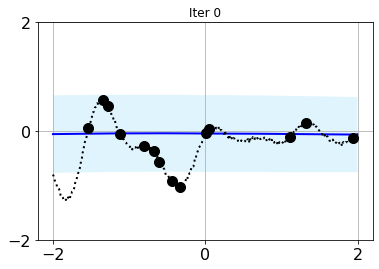

train: 100 loss= 0.4587 val_loss= 0.6413
train: 200 loss= 0.2329 val_loss= 0.6051
train: 300 loss= 0.3573 val_loss= 1.295
train: 400 loss= 0.426 val_loss= 0.5766
train: 500 loss=-0.08328 val_loss= 0.5137
train: 600 loss= 0.1441 val_loss= 1.05
train: 700 loss=-0.09933 val_loss= 1.253
train: 800 loss=-0.2678 val_loss= 0.8743
train: 900 loss= 0.04808 val_loss=-0.0923
train: 1000 loss= 0.3288 val_loss= 0.3959


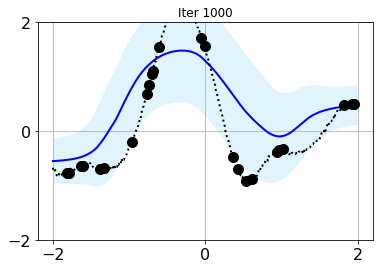

train: 1100 loss= 0.1042 val_loss= 0.8696
train: 1200 loss=-0.07648 val_loss= 0.7987
train: 1300 loss=-0.1327 val_loss= 0.5146
train: 1400 loss= 0.01851 val_loss= 1.122
train: 1500 loss=-0.1384 val_loss= 0.267
train: 1600 loss= 1.163 val_loss= 0.8228
train: 1700 loss= 0.002209 val_loss=-0.6582
train: 1800 loss= 0.02812 val_loss=-0.5332
train: 1900 loss= 0.03089 val_loss= 1.108
train: 2000 loss= 0.0444 val_loss= 0.268


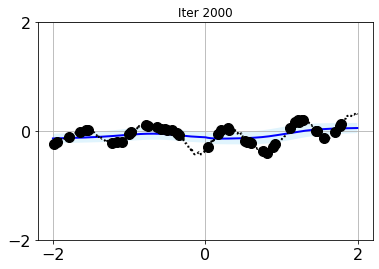

train: 2100 loss= 0.3157 val_loss= 0.2536
train: 2200 loss=-0.1212 val_loss= 1.005
train: 2300 loss=-0.1426 val_loss=-0.4149
train: 2400 loss= 0.4952 val_loss= 2.515
train: 2500 loss=-0.02337 val_loss= 0.6737
train: 2600 loss=-0.1221 val_loss= 1.173
train: 2700 loss=-0.2397 val_loss= 0.08649
train: 2800 loss=-0.262 val_loss= 2.026
train: 2900 loss= 0.3973 val_loss= 1.033
train: 3000 loss= 0.473 val_loss= 0.3988


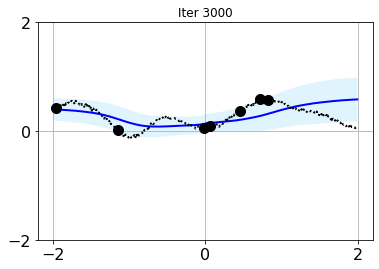

train: 3100 loss= 0.1286 val_loss= 0.7313
train: 3200 loss= 0.1505 val_loss=-0.4278
train: 3300 loss= 0.1239 val_loss= 0.07454
train: 3400 loss=-0.3603 val_loss=-0.6223
train: 3500 loss= 0.1256 val_loss= 0.1965
train: 3600 loss= 0.1861 val_loss= 0.3888
train: 3700 loss=-0.02808 val_loss=-1.615
train: 3800 loss= 0.002729 val_loss= 0.4251
train: 3900 loss= 0.09646 val_loss=-1.225
train: 4000 loss= 0.08507 val_loss= 0.1615


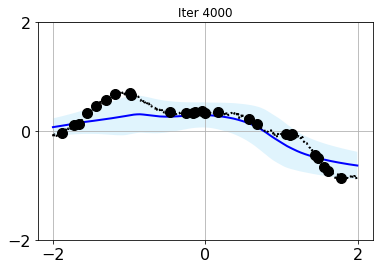

train: 4100 loss= 0.3127 val_loss= 0.002504
train: 4200 loss= 0.183 val_loss= 1.372
train: 4300 loss= 0.4749 val_loss=-0.8027
train: 4400 loss= 0.02496 val_loss= 0.5185
train: 4500 loss=-0.05285 val_loss= 1.298
train: 4600 loss=-0.059 val_loss=-0.7782
train: 4700 loss=-0.3106 val_loss=-0.7015
train: 4800 loss=-0.01025 val_loss= 0.03005
train: 4900 loss=-0.01599 val_loss= 1.313
train: 5000 loss=-0.03248 val_loss= 0.1122


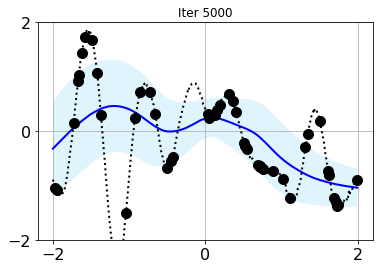

train: 5100 loss=-0.1601 val_loss=-0.7915
train: 5200 loss=-0.2264 val_loss= 0.02281
train: 5300 loss= 0.585 val_loss= 0.4562
train: 5400 loss= 0.00639 val_loss= 1.94
train: 5500 loss=-0.2998 val_loss=-0.02642
train: 5600 loss=-0.2697 val_loss= 0.4015
train: 5700 loss=-0.151 val_loss= 2.61
train: 5800 loss=-0.04946 val_loss= 0.03269
train: 5900 loss=-0.1889 val_loss=-0.07903
train: 6000 loss=-0.718 val_loss=-1.348


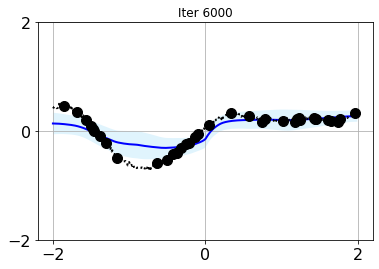

train: 6100 loss=-0.07253 val_loss=-0.06845
train: 6200 loss=-0.2002 val_loss= 0.758
train: 6300 loss=-0.2808 val_loss= 0.2902
train: 6400 loss= 0.1788 val_loss= 0.4741
train: 6500 loss=-0.1916 val_loss=-0.497
train: 6600 loss=-0.4884 val_loss= 0.1198
train: 6700 loss= 0.3179 val_loss=-1.102
train: 6800 loss=-0.2717 val_loss= 0.1815
train: 6900 loss= 0.1442 val_loss= 0.06652
train: 7000 loss=-0.2529 val_loss= 0.2183


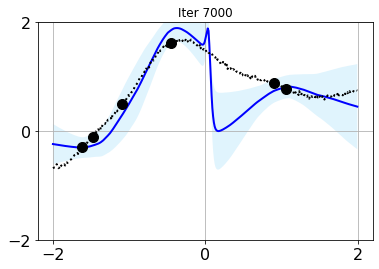

train: 7100 loss=-0.5139 val_loss=-1.043
train: 7200 loss= 0.1175 val_loss= 0.2555
train: 7300 loss=-0.01821 val_loss=-0.5002
train: 7400 loss=-0.1937 val_loss= 0.7815
train: 7500 loss=-0.2515 val_loss= 1.878
train: 7600 loss=-0.4304 val_loss= 0.2497
train: 7700 loss=-0.4573 val_loss=-0.5104
train: 7800 loss=-0.1097 val_loss=-1.595
train: 7900 loss=-0.169 val_loss=-0.5469
train: 8000 loss=-0.4157 val_loss=-0.652


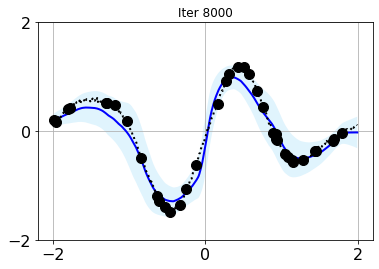

train: 8100 loss= 0.02136 val_loss=-0.3302
train: 8200 loss=-0.242 val_loss= 4.426
train: 8300 loss=-0.2305 val_loss=-0.1257
train: 8400 loss=-0.4046 val_loss= 0.007771
train: 8500 loss=-0.3791 val_loss=-0.5331
train: 8600 loss=-0.3371 val_loss= 0.4644
train: 8700 loss=-0.06009 val_loss= 1.061
train: 8800 loss=-0.01898 val_loss= 0.01321
train: 8900 loss=-0.7999 val_loss=-1.097
train: 9000 loss= 0.2256 val_loss=-0.1066


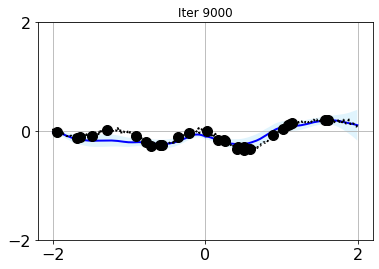

train: 9100 loss=-0.01695 val_loss=-0.6275
train: 9200 loss= 0.1429 val_loss= 0.3768
train: 9300 loss= 0.108 val_loss=-0.2208
train: 9400 loss=-0.4627 val_loss= 0.3817
train: 9500 loss=-0.5703 val_loss=-0.3627
train: 9600 loss=-0.2133 val_loss=-0.5779
train: 9700 loss=-0.5141 val_loss=-0.7667
train: 9800 loss=-0.605 val_loss=-0.194
train: 9900 loss= 0.4604 val_loss= 0.5109
train: 10000 loss= 0.08941 val_loss=-0.4082


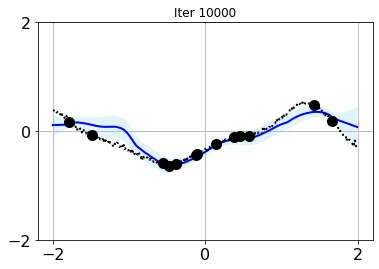

train: 10100 loss=-0.05301 val_loss= 0.3748
train: 10200 loss=-0.3752 val_loss=-0.7454
train: 10300 loss=-0.5065 val_loss=-1.36
train: 10400 loss=-0.1608 val_loss=-0.4235
train: 10500 loss=-0.3573 val_loss=-0.1387
train: 10600 loss=-0.007047 val_loss= 0.7716
train: 10700 loss=-0.002887 val_loss=-0.2827
train: 10800 loss=-0.6093 val_loss= 0.6792
train: 10900 loss=-0.3313 val_loss=-1.244
train: 11000 loss=-0.5322 val_loss= 0.9645


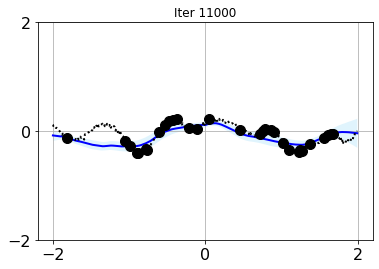

train: 11100 loss=-0.7242 val_loss= 0.5701
train: 11200 loss=-0.9163 val_loss= 1.758
train: 11300 loss=-0.7383 val_loss=-0.7432
train: 11400 loss=-0.3554 val_loss= 0.6336
train: 11500 loss=-0.3788 val_loss=-1.637
train: 11600 loss=-0.1507 val_loss= 0.947
train: 11700 loss= 0.2748 val_loss=-0.4106
train: 11800 loss=-0.8627 val_loss=-0.4712
train: 11900 loss=-0.02113 val_loss= 1.296
train: 12000 loss=-0.4049 val_loss= 1.174


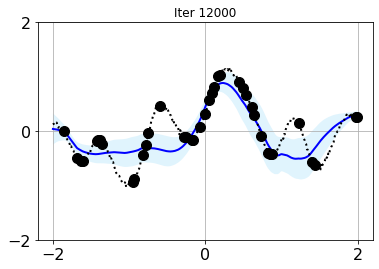

train: 12100 loss=-0.6371 val_loss= 1.407
train: 12200 loss=-0.7504 val_loss=-1.054
train: 12300 loss=-0.5446 val_loss=-1.731
train: 12400 loss=-0.6009 val_loss=-0.5427
train: 12500 loss=-0.3949 val_loss=-0.9042
train: 12600 loss=-0.4139 val_loss=-0.3413
train: 12700 loss=-0.7882 val_loss= 0.7199
train: 12800 loss=-0.2358 val_loss= 0.4558
train: 12900 loss=-0.133 val_loss= 1.631
train: 13000 loss=-0.8925 val_loss=-0.2054


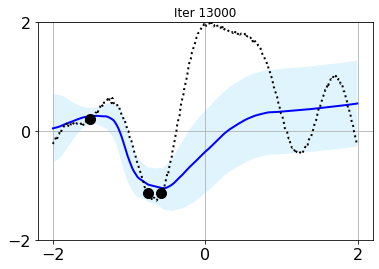

train: 13100 loss=-0.3349 val_loss= 0.6909
train: 13200 loss=-0.3534 val_loss=-0.5158
train: 13300 loss=-0.4553 val_loss= 1.181
train: 13400 loss=-0.2239 val_loss=-0.4758
train: 13500 loss=-0.5028 val_loss= 0.7517
train: 13600 loss=-0.5748 val_loss= 1.059
train: 13700 loss=-0.8389 val_loss= 0.08524
train: 13800 loss=-0.7235 val_loss= 0.2337
train: 13900 loss=-0.6328 val_loss=-0.4903
train: 14000 loss=-0.7552 val_loss= 0.6968


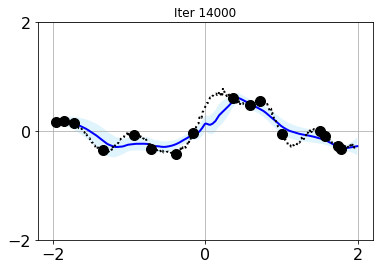

train: 14100 loss=-0.513 val_loss=-1.127
train: 14200 loss=-1.21 val_loss=-0.09703
train: 14300 loss=-0.4397 val_loss=-0.8424
train: 14400 loss=-0.7667 val_loss=-0.1598
train: 14500 loss=-0.5753 val_loss=-0.09461
train: 14600 loss=-0.5541 val_loss= 0.8457
train: 14700 loss=-0.2401 val_loss=-1.294
train: 14800 loss=-0.3916 val_loss= 0.8861
train: 14900 loss=-0.5086 val_loss=-0.8828
train: 15000 loss=-0.6116 val_loss=-0.2872


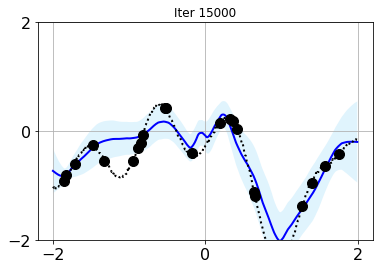

train: 15100 loss=-0.3264 val_loss=-0.9836
train: 15200 loss=-0.6587 val_loss=-0.5693
train: 15300 loss=-0.4401 val_loss=-1.634
train: 15400 loss=-0.6585 val_loss= 0.9375
train: 15500 loss=-0.5953 val_loss=-0.9451
train: 15600 loss=-0.7546 val_loss= 0.4929
train: 15700 loss=-0.9229 val_loss= 0.3884
train: 15800 loss=-0.5856 val_loss=-0.2925
train: 15900 loss=-0.2148 val_loss=-0.8883
train: 16000 loss=-0.7017 val_loss=-0.3683


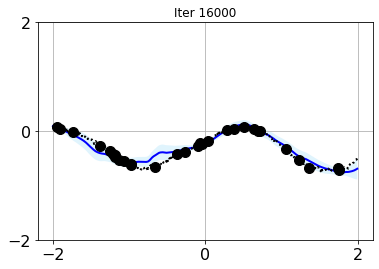

train: 16100 loss=-0.461 val_loss= 0.08153
train: 16200 loss=-0.6937 val_loss=-1.902
train: 16300 loss=-0.814 val_loss=-0.2374
train: 16400 loss=-0.5636 val_loss=-1.466
train: 16500 loss= 0.275 val_loss= 1.016
train: 16600 loss=-0.5511 val_loss=-0.8371
train: 16700 loss=-0.7323 val_loss= 0.9235
train: 16800 loss=-0.6481 val_loss=-0.06874
train: 16900 loss= 0.2401 val_loss=-1.002
train: 17000 loss=-0.1661 val_loss=-0.7689


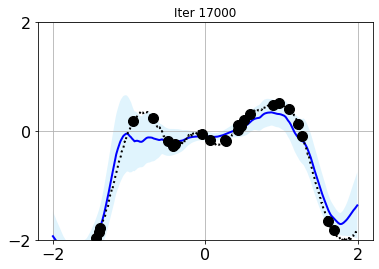

train: 17100 loss=-0.4972 val_loss= 2.187


KeyboardInterrupt: 

In [49]:


writer = SummaryWriter(comment='-anp_1d_reg')
print(writer.logdir)

hparams = dict(
    x_dim=1,
    y_dim=1,
    hidden_dim=128,
    latent_dim=128,
    latent_enc_self_attn_type="multihead",
    det_enc_self_attn_type="multihead",
    det_enc_cross_attn_type="multihead")
model = LatentModel(**hparams).cuda()

optim = torch.optim.Adam(model.parameters(), lr=1e-4)

for n_iter in tqdm(range(epochs)):
    model.train()

    data_train = dataset_train.generate_curves()

    (context_x, context_y), target_x = data_train.query
    target_y = data_train.target_y

    context_x = context_x.cuda()
    context_y = context_y.cuda()
    target_x = target_x.cuda()
    target_y = target_y.cuda()

    optim.zero_grad()
    y_pred, kl, loss, mse_loss, y_std = model(context_x, context_y, target_x,
                                              target_y)
    loss.backward()
    optim.step()

    writer.add_scalar('train/loss', loss, n_iter)
    writer.add_scalar('train/mse_loss', mse_loss, n_iter)
    writer.add_scalar('train/y_std', y_std.mean(), n_iter)
    writer.add_scalar('train/kl', kl.mean(), n_iter)

    if n_iter % PRINT_AFTER == 0:
        y_pred, kl, val_loss, y_std = test(
            model, dataset_test, writer, plot=False, global_step=n_iter)
        print(
            f"train: {n_iter} loss={loss.item(): 4.4g} val_loss={val_loss.item(): 4.4g}"
        )

    if n_iter % PLOT_AFTER == 0:
        test(model, dataset_test, writer, plot=True, global_step=n_iter)

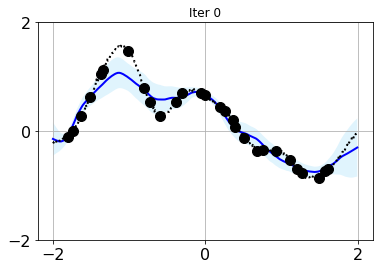

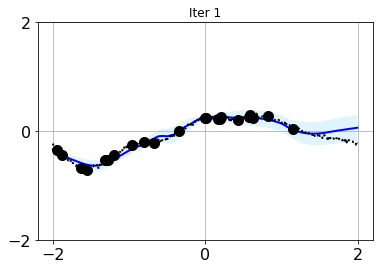

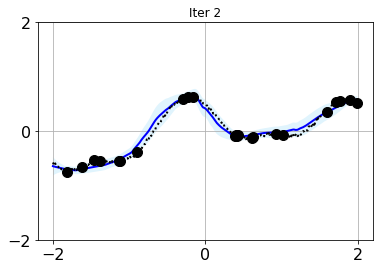

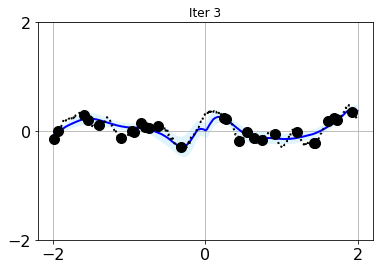

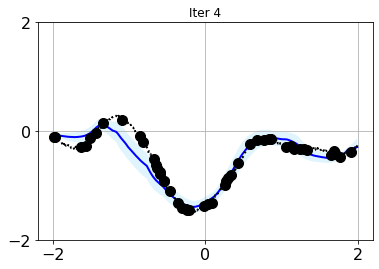

In [50]:
for i in range(5):
    set_seed(i)
    test(model, dataset_test, writer, plot=True, global_step=i)

In [51]:
# Final validation
loss = torch.stack([test(model, dataset_test)[2] for _ in tqdm(range(100))]).mean().cpu()
print('val loss (n=100)', loss)
writer.add_hparams(hparams, dict(val_loss=loss))


val loss (n=100) tensor(-0.3734)


## Improved

These have no been extensively tested:

- use torches ~50% faster multiheaded attention
- calc loss in log domain for stability (and untested changes to clipping)
- dropout

runs/Feb01_13-07-48_mjcdesktop-anp_1d_impr


train: 0 loss= 1.559 val_loss= 1.574


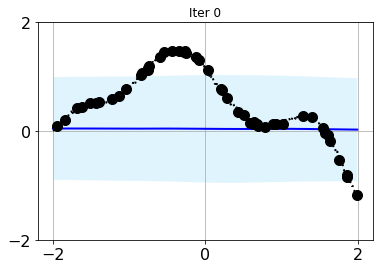

train: 100 loss= 1.02 val_loss= 0.8722


In [ ]:
writer = SummaryWriter(comment='-anp_1d_impr')
print(writer.logdir)
                 
hparams = dict(
    x_dim=1,
    y_dim=1,
    hidden_dim=128,
    latent_dim=128,
    latent_enc_self_attn_type="ptmultihead",
    det_enc_self_attn_type="ptmultihead",
    det_enc_cross_attn_type="ptmultihead",
    use_lvar=True,
    use_self_attn=True,
#     attention_dropout=0.3,
    dropout=0.3,
#     batchnorm=True,
)
model = LatentModel(**hparams).cuda()

optim = torch.optim.Adam(model.parameters(), lr=1e-4)

for n_iter in tqdm(range(epochs)):
    model.train()

    data_train = dataset_train.generate_curves()

    (context_x, context_y), target_x = data_train.query
    target_y = data_train.target_y

    context_x = context_x.cuda()
    context_y = context_y.cuda()
    target_x = target_x.cuda()
    target_y = target_y.cuda()

    optim.zero_grad()
    y_pred, kl, loss, mse_loss, y_std = model(context_x, context_y, target_x,
                                              target_y)
    loss.backward()
    optim.step()

    writer.add_scalar('train/loss', loss, n_iter)
    writer.add_scalar('train/mse_loss', mse_loss, n_iter)
    writer.add_scalar('train/y_std', y_std.mean(), n_iter)
    writer.add_scalar('train/kl', kl.mean(), n_iter)

    if n_iter % PRINT_AFTER == 0:
        y_pred, kl, val_loss, y_std = test(
            model, dataset_test, writer, plot=False, global_step=n_iter)
        print(
            f"train: {n_iter} loss={loss.item(): 4.4g} val_loss={val_loss.item(): 4.4g}"
        )

    if n_iter % PLOT_AFTER == 0:
        test(model, dataset_test, writer, plot=True, global_step=n_iter)

In [ ]:
for i in range(5):
    set_seed(i)
    test(model, dataset_test, writer, plot=True, global_step=i)

In [ ]:
# Final validation
loss = torch.stack([test(model, dataset_test)[2] for _ in tqdm(range(100))]).mean().cpu()
print('val loss (n=100)', loss)
writer.add_hparams(hparams, dict(val_loss=loss))

In [ ]:
(hparams, dict(val_loss=loss))